In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [21]:
import numpy as np
import os
import zipfile
import pandas as pd
import random
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
print("Tensorflow version: ", tf.__version__)

# tf.compat.v1.disable_eager_execution()

Tensorflow version:  2.11.0


In [22]:
# Unzip data
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")

In [24]:
SEED = 2405
tf.random.set_seed(SEED)

In [25]:
IMAGE_DIR = './train'
TEST_DIR = './test1'
# Create dataframe
filenames = os.listdir(IMAGE_DIR)
labels = [x.split(".")[0] for x in filenames]
df = pd.DataFrame({"filename": filenames, "label": labels})
df.head()

,filename,label
0,dog.7601.jpg,dog
1,cat.2983.jpg,cat
2,cat.3264.jpg,cat
3,cat.1082.jpg,cat
4,cat.4959.jpg,cat


In [26]:
test_filenames = os.listdir(TEST_DIR)
# test_labels = [x.split(".")[0] for x in test_filenames]
test_df = pd.DataFrame({"filename": test_filenames})
test_df.head()

,filename
0,3614.jpg
1,12104.jpg
2,8212.jpg
3,3371.jpg
4,11901.jpg


In [27]:
df.label.value_counts()

dog    12500
cat    12500
Name: label, dtype: int64

In [28]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(train_df.label.value_counts())
print(val_df.label.value_counts())

dog    10002
cat     9998
Name: label, dtype: int64
cat    2502
dog    2498
Name: label, dtype: int64


In [29]:
train_df.head()

,filename,label
0,cat.12361.jpg,cat
1,dog.1658.jpg,dog
2,dog.9830.jpg,dog
3,dog.2221.jpg,dog
4,cat.9779.jpg,cat


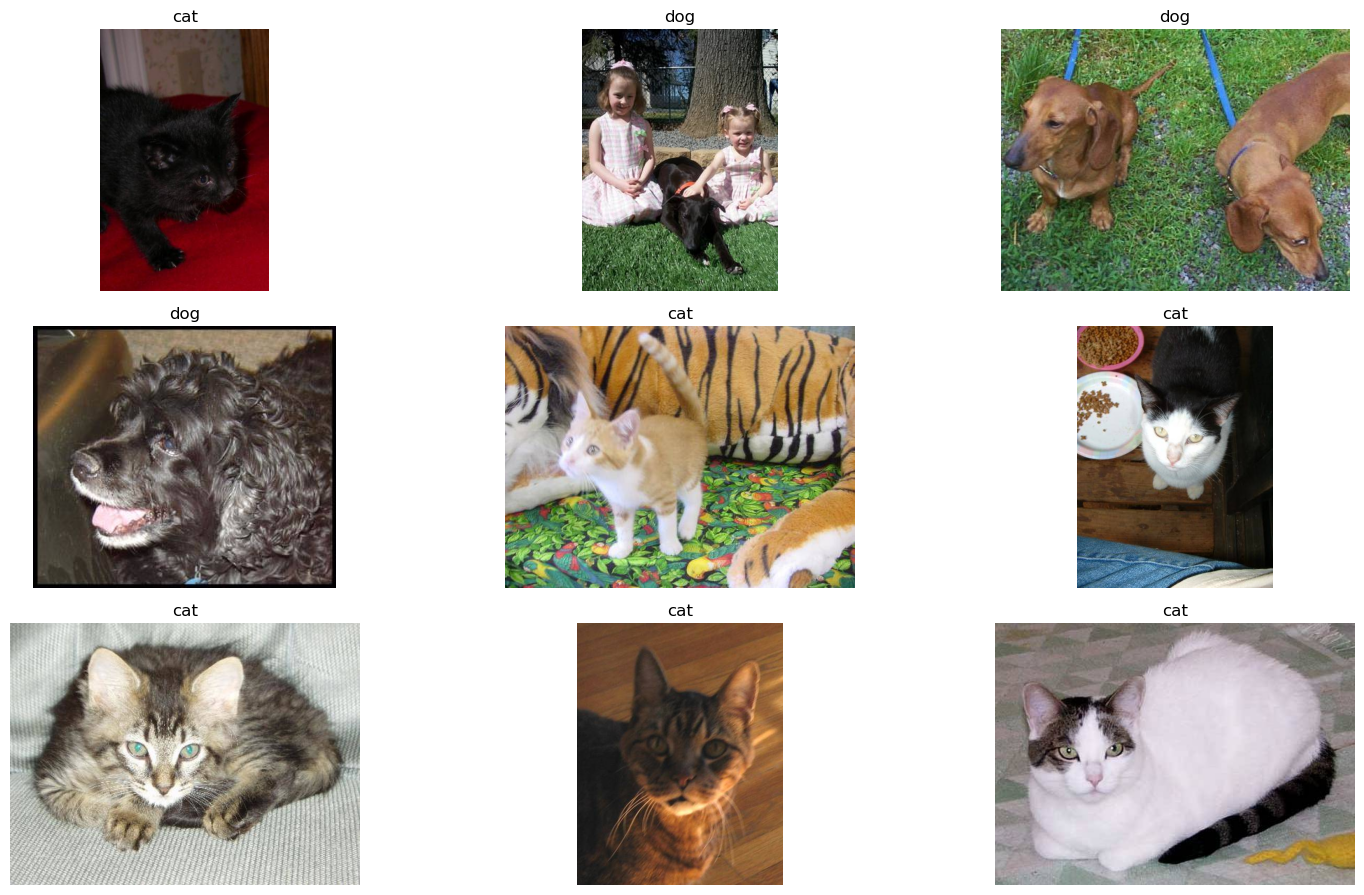

In [30]:
plt.figure(figsize=(15,15))
for i in range(0, 9):
    plt.subplot(5,3,i+1)
    filename, label = train_df.iloc[i]
    img = cv2.imread(os.path.join(IMAGE_DIR, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [31]:
resnet = ResNet50V2(include_top=False, pooling="avg", weights='imagenet')
for layer in resnet.layers:
    layer.trainable=False

logits = Dense(2)(resnet.layers[-1].output)
output = Activation('softmax')(logits)
model = Model(resnet.input, output)

In [32]:
adam = optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss = "categorical_crossentropy", metrics=["accuracy"])

In [33]:
earlystoper = EarlyStopping(monitor="val_loss", patience=5)
checkpointer = ModelCheckpoint(filepath="../working/resnet50best.hdf5", monitor='val_loss', save_best_only=True, mode='auto')
callbacks = [earlystoper, checkpointer]

In [34]:
batch_size = 100
W, H = 100, 100
epochs = 10

In [35]:
# Train generator
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = train_datagen.flow_from_dataframe(train_df, IMAGE_DIR, x_col="filename", y_col="label",
                                                    target_size=(W,H), class_mode="categorical",
                                                   batch_size=batch_size, shuffle=True, seed=SEED)
# Validation generator
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
val_generator = val_datagen.flow_from_dataframe(val_df, IMAGE_DIR, x_col="filename", y_col="label",
                                               target_size=(W,H), class_mode="categorical",
                                                batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [36]:
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=20,
    steps_per_epoch=20,
    callbacks=callbacks
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
20/20 [==============================] - 21s 648ms/step - loss: 1.1030 - accuracy: 0.6255 - val_loss: 0.9127 - val_accuracy: 0.6440
Epoch 2/10
20/20 [==============================] - 16s 816ms/step - loss: 0.7987 - accuracy: 0.7150 - val_loss: 0.6439 - val_accuracy: 0.7490
Epoch 3/10
20/20 [==============================] - 16s 844ms/step - loss: 0.5868 - accuracy: 0.7690 - val_loss: 0.5484 - val_accuracy: 0.7860
Epoch 4/10
20/20 [==============================] - 16s 825ms/step - loss: 0.5001 - accuracy: 0.8055 - val_loss: 0.4523 - val_accuracy: 0.8225
Epoch 5/10
20/20 [==============================] - 16s 817ms/step - loss: 0.4761 - accuracy: 0.8170 - val_loss: 0.4359 - val_accuracy: 0.8245
Epoch 6/10
20/20 [==============================] - 12s 600ms/step - loss: 0.4123 - accuracy: 0.8300 - val_loss: 0.3996 - val_accuracy: 0.8490
Epoch 7/10
20/20 [==============================] - 16s 827ms/step - loss: 0.4041 - accuracy: 0.8415 - val_loss: 0.3798 - val_accuracy: 0.8455

In [37]:
model.load_weights("../working/resnet50best.hdf5")

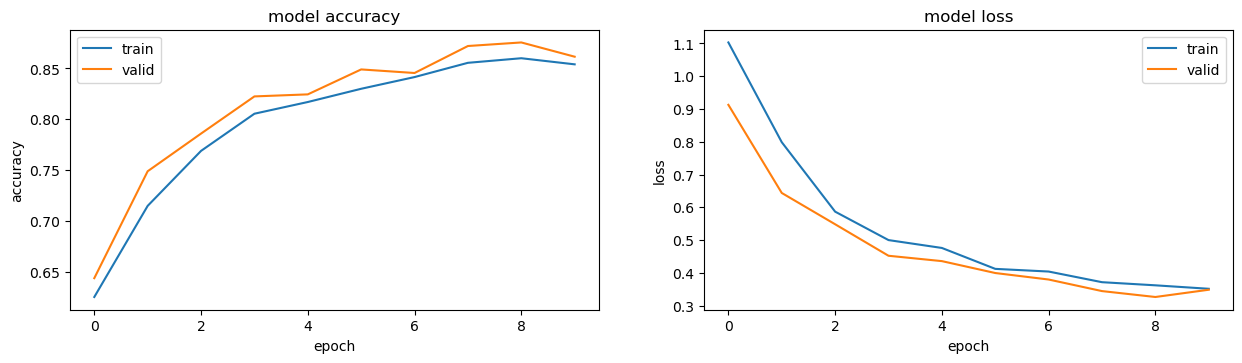

In [38]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
# Saliency Map
# get the symbolic outputs of each "key" layer
layer_dict = dict([(layer.name, layer) for layer in model.layers])

for layer in model.layers:
  print(layer.name)
# dense 2 and activation 2 are extra

In [ ]:
filename = test_df.iloc[23]['filename']
print(filename)
img1 = cv2.imread(os.path.join(TEST_DIR, filename))
print(img1.shape)
img1 = cv2.resize(img1, (200, 200))
print(img1.shape)
plt.imshow(img1)
plt.tight_layout()
plt.show()
img = np.expand_dims(img1, axis=0)
img = preprocess_input(img)

In [ ]:
# util function to convert a tensor into a valid image
def tensor2image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.2
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
pred = model.predict(img)
print(pred)

In [ ]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(100000)

In [ ]:
print(model.input)

In [ ]:
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

In [ ]:
print(model.input)

In [ ]:
model_out = K.mean(layer_dict['dense_1'].output)
# compute the gradient of the input picture wrt this loss
grads = K.gradients(model_out, model.input)[0]

# Normalize the gradient
grads /= K.std(grads) + 1e-8

# function: returns the loss and grads given the input picture
model_predictor = K.function([model.input], [model_out, grads])

In [ ]:
# feed  the image to the network
model_outputs, grads_values = model_predictor([img])

In [ ]:
# get the grads that have the same shape  as the input image  
abs_grads_values = np.abs(grads_values)
sm = tensor2image(abs_grads_values[0])
print(sm.shape)

In [ ]:
# let's see the grads as an image
gs = sm[:,:,0] + sm[:,:,1] + sm[:,:,2]
gs[gs<150] = 0
plt.figure(figsize=(6,6))
plt.imshow(gs, cmap='Blues_r')
plt.colorbar()

In [ ]:
plt.figure(2, figsize = (12,12)) 
    
plt.subplot(221)  
plt.imshow(img1) 
    
plt.subplot(222)  
plt.imshow(sm)

plt.show()

In [39]:
for i in [2,11,23,58]:
    print(model.layers[i].name)

conv1_conv
conv2_block1_2_conv
conv2_block2_2_conv
conv3_block2_2_conv


In [40]:
for i in [2,7, 11,23,38, 58]:
    print(model.layers[i].name)

conv1_conv
conv2_block1_1_conv
conv2_block1_2_conv
conv2_block2_2_conv
conv2_block3_3_conv
conv3_block2_2_conv
